# Salient Maps

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from wilds import get_dataset
from utils.datasets import BinaryDataset

from collections import OrderedDict

/home/htc/kchitranshi/learning-from-adversarial-perturbations/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [11]:
def saliency(img, label, model, mode='Original'):
    plt.figure(figsize=(8, 4))
    
    # Disable gradient calculation for model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Prepare input image
    input = img.detach()
    input.unsqueeze_(0)  # Add batch dimension
    input.requires_grad = True
    
    # Set model to evaluation mode
    model.zero_grad()
    model.eval()

    # Forward pass
    preds = model(input)
    #score = preds * label
    # Get score for target class
    score, _ = torch.max(preds, 1)
    
    
    # Backward pass to get gradients
    score.backward()
    
    # Get maximum absolute gradient across color channels
    sal, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    
    # Normalize saliency map to [0,1] range
    sal = (sal - sal.min())/(sal.max()-sal.min())
    
    # Get original image without normalization
    with torch.no_grad():
        input_img = inv_normalize(input[0])

    predicted_label = "WaterBird" if preds.argmax(dim=1).item() == 1 else "LandBird"
    Class = "LandBird" if label.item() == 0 else "WaterBird"
    
    print(f'Mode: {mode}')
    print(f"Predicted label: {predicted_label}, True label: {Class}")

    # Plot original image
    plt.subplot(1, 2, 1, title=f'Original Image')
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    
    # Plot saliency map
    plt.subplot(1, 2, 2, title=f'{mode} Saliency')
    plt.imshow(sal.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(f'./results/saliency_maps/WaterBirds_{mode}_{Class}.jpg', bbox_inches='tight', dpi=300)
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.imshow(sal.numpy(), cmap='hot')
    plt.axis('off')
    plt.savefig(f'./results/saliency_maps/WaterBirds_{mode}_{Class}_saliency_map.jpg', bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.savefig(f'./results/saliency_maps/WaterBirds_{mode}_{Class}_original.jpg', bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()


In [4]:
def prep_model(model_path, mode='Original'):
    if mode in ['L2', 'Linf', 'GDPR_CFE', 'SCFE']:
        state_dict = torch.load(model_path,weights_only=False)['adv_classifier']
    elif mode == 'Original':
        state_dict = torch.load(model_path)
    else:
        NotImplementedError
        
    state_dict = OrderedDict((k.replace('model.resnet.', '', 1), v) for k, v in state_dict.items())
    
    model = torchvision.models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(state_dict=state_dict)
    model.to('cpu')
    return model

In [5]:
main_dataset = get_dataset(dataset="waterbirds", download=False,root_dir='../SCRATCH/')
data = main_dataset.get_subset("val", transform=transform)
data = BinaryDataset(data,which_dataset='waterbirds')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


Mode: Original
Predicted label: WaterBird, True label: LandBird


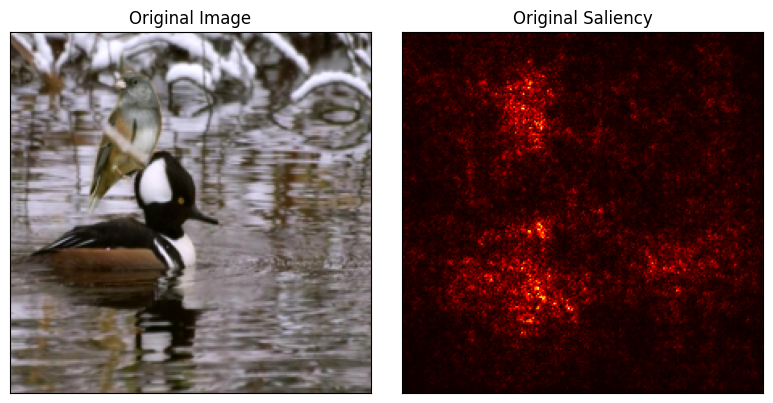

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


Mode: L2
Predicted label: LandBird, True label: LandBird


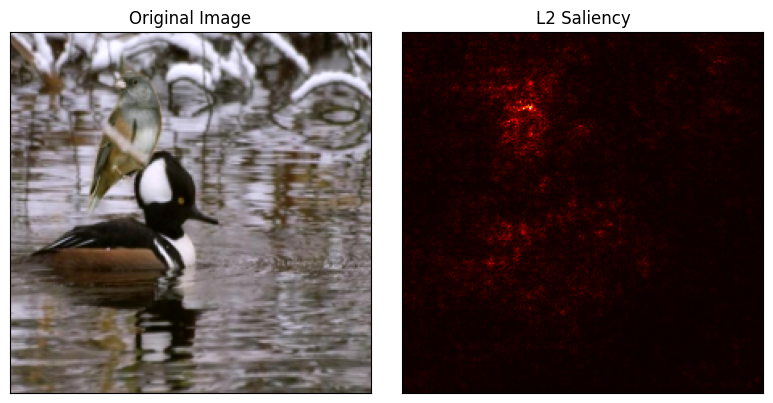

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


Mode: Linf
Predicted label: LandBird, True label: LandBird


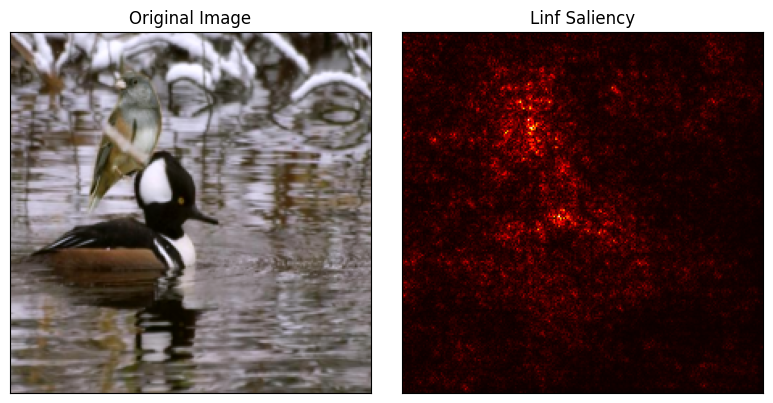

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


Mode: GDPR_CFE
Predicted label: LandBird, True label: LandBird


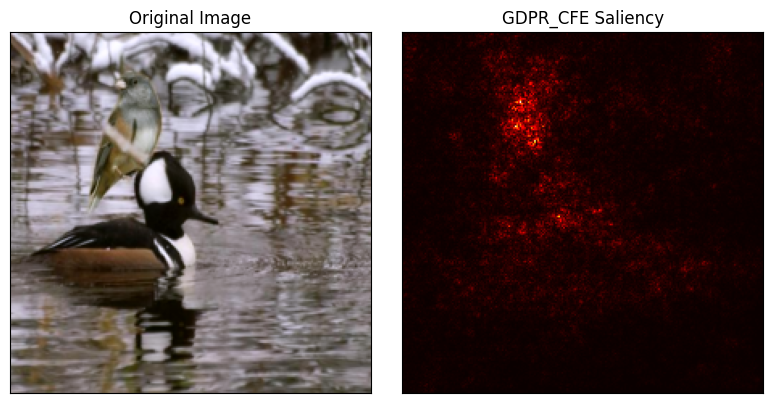

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


Mode: SCFE
Predicted label: LandBird, True label: LandBird


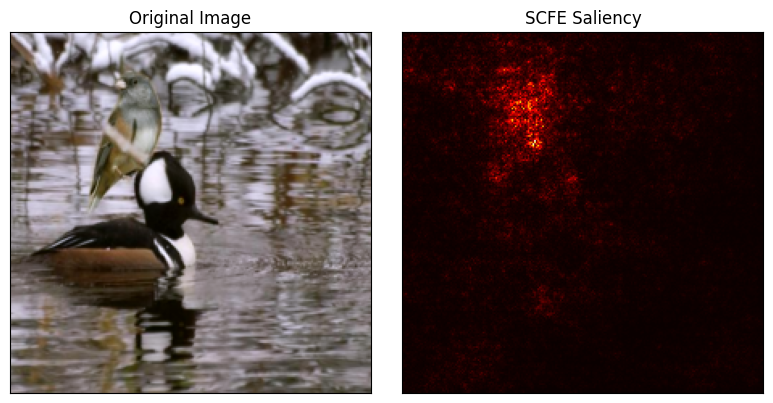

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


In [44]:
sample_idx = 433 # maybe 129, 345, 433
mode_list = ['Original', 'L2', 'Linf', 'GDPR_CFE','SCFE']

for mode in mode_list:
    if mode in ['L2', 'Linf', 'GDPR_CFE', 'SCFE']:
        model = prep_model(model_path=f"../SCRATCH/WaterBirds_{mode}", mode=mode)
    elif mode == 'Original':
        model = prep_model(model_path=f"../SCRATCH/CFE_models/waterbirds_clean_035084af-b895-433b-bdf9-46cba06e8f51.pt", mode=mode)
    else:
        NotImplementedError

    saliency(data[sample_idx][0], data[sample_idx][1], model, mode)